# Lab 3 - Asking a Statistical Question

##### PHYS434 - Advanced Laboratory: Computational Data Analysis
##### Professor: Miguel Morales
<br>

##### Due date: 10/23/2021
##### By Erik Solhaug
<br>

This week we are going to concentrate on asking a statistical question. This process almost always consists of 3+ steps:
 1. Writing down in words very precisely what question you are trying to ask.
 2. Translating the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and the to integral to do to obtain a probability. 
 3. Coverting the probability into equivalent sigma
 
 

In [1]:
# Importing needed libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, signal
from astropy import units as u

# This sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)
# This sets the fontsize of the x- and y-labels
fsize = 30
lsize = 24

## Problem 1

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

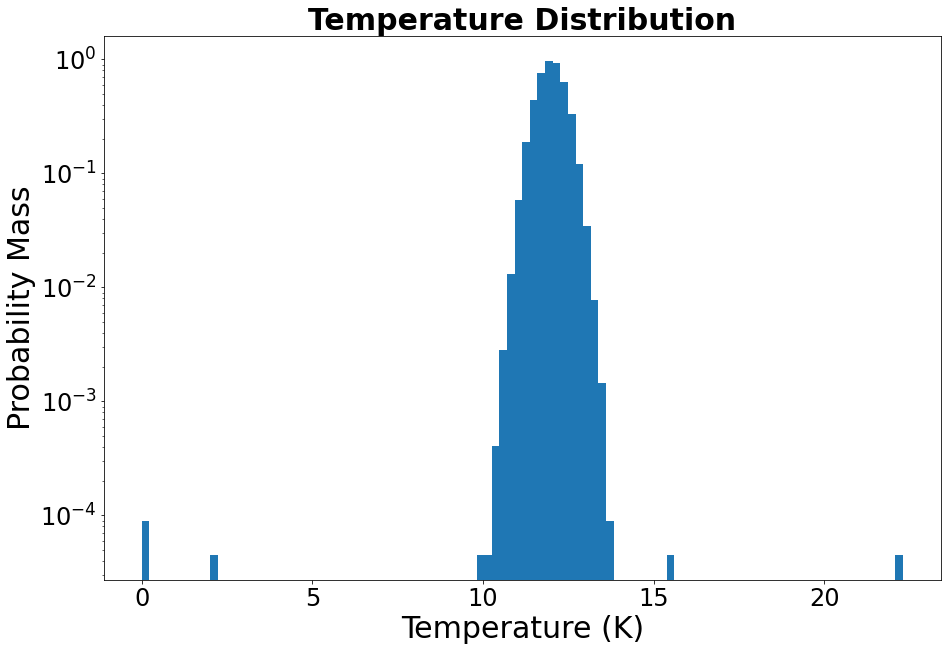

In [2]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

## A)

### 1.

Let's play around with the data and come up with criteria for throwing out certain data points.

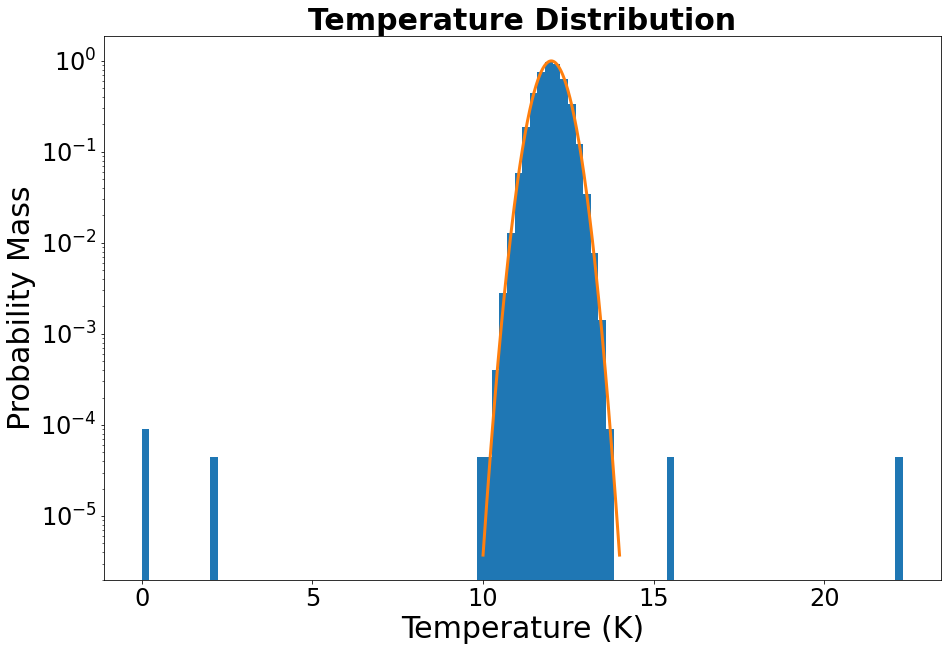

In [3]:
x = np.linspace(10, 14, 1000)
d2 = stats.norm.pdf(x, loc = 12., scale = 0.4)
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
ax.plot(x, d2, linewidth = 3)
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

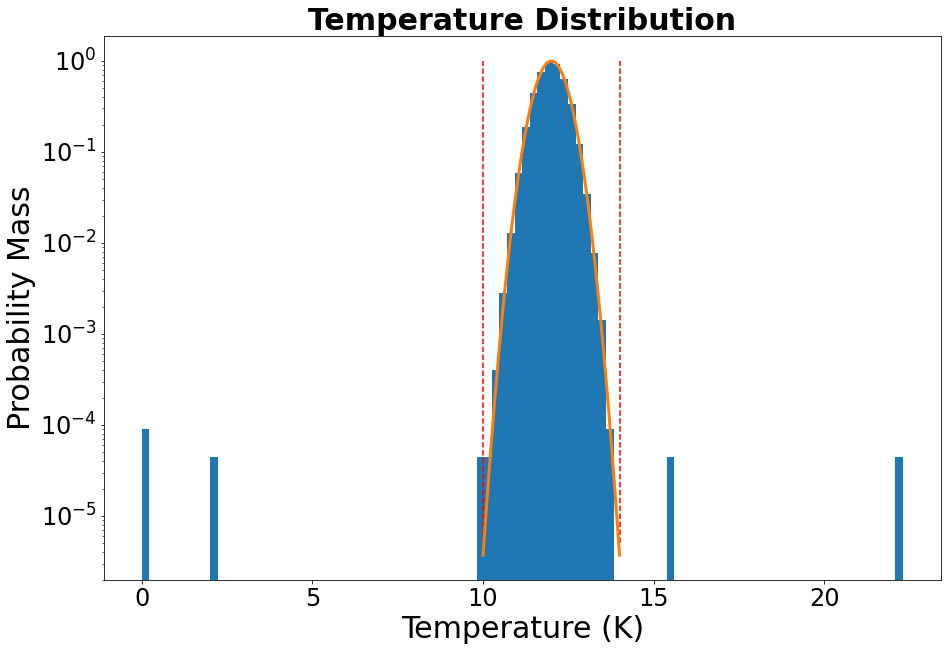

In [4]:
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
ax.plot(x, d2, linewidth = 3)
ax.vlines(10, 5e-6, 1e0, color='r', linestyle = '--')
ax.vlines(14, 5e-6, 1e0, color='r', linestyle = '--')
plt.tick_params(labelsize = 24)
plt.yscale('log')
ax.set_xlabel('Temperature (K)', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('Temperature Distribution', fontsize = fsize, fontweight = 'bold')
plt.show()

Let's suggest boundaries of values 10 and 14 (+-2 on each side of the mean) to discriminate 'bad' data points - essentially, setting these as thresholds for the data to be in between. 

### 2.

If we take the survival function of 14 under our pdf we get the following probability and sigma:

In [5]:
norm_dist = stats.norm(loc = 12., scale = 0.4)
prob = norm_dist.sf(14)
sigma = round(-stats.norm.ppf(prob, loc=0, scale=1), 4)
sigma

5.0

This seems to be a good threshold for our data - so that if the data value lies beyond five sigma from the mean of the distribution, then we will throw the data point away. 5 sigma seems to be placed right outside the majority of our distribution and excludes the data point that are outliers.

Then, our statistical question becomes:

_Is the probability of getting the data point in our distribution smaller than $5\sigma$?_

If this is the case, we will throw out the data point.

### 3.

We now restate our question in mathematical terms. For a data point with value $V$.

In [6]:
def exclude_data(dist, V, sigma):
    '''
    Returns True if data point should be thrown out,
            False if it should be kept.
    '''
    Vprob = dist.sf(V)
    Vsigma = -stats.norm.ppf(Vprob, loc=0, scale=1)
    if abs(Vsigma) > sigma:
        exclude = True
    else:
        exclude = False
    return exclude

We run this in a loop and get:

In [7]:
included_array = []
excluded_array = []
for item in d:
    if exclude_data(norm_dist, item, sigma):
        excluded_array.append(item)
    else:
        included_array.append(item)
print(f'Excluded: {excluded_array}\n\n'
      f'Included: {included_array}')

Excluded: [2.1, 0.0, 0.0, 15.6, 22.3]

Included: [11.761452398242664, 11.791361662786915, 11.953622952210583, 11.668347962641931, 11.66214497601433, 11.12417073396756, 11.9655635512586, 12.424536947686256, 12.235838173330901, 12.065696640160933, 12.1941104205101, 11.891598111658308, 11.154335710238948, 12.305663690926691, 11.978876158273001, 12.14635524758597, 12.13073552639809, 12.098878226117465, 12.279429241485763, 12.072435668342832, 11.862124243057169, 12.633382327000364, 11.659967242646642, 12.520118939212898, 12.086054869353807, 12.308985652324646, 12.211565524625906, 11.448245106217254, 11.698194622179747, 12.058561986824364, 11.891460459292261, 11.646140004024023, 12.058755478697782, 11.455342205551435, 11.941818214475896, 12.203223281579572, 11.935016032129868, 12.153159429527395, 11.41887446038508, 11.86929768395305, 11.5668082450873, 11.394087232577482, 11.962867437109024, 12.094759735488859, 11.840396114401523, 11.732597998219132, 10.704818725099003, 10.983254736028487, 12

### 4.

Reminder: Our 'bad' data points are {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

In [8]:
bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
kept_bad_data = []
for i in included_array:
    for k in bad_data:
        if i == k:
            kept_bad_data.append(i)
bad_data, kept_bad_data

([10.0, 10.3, 2.1, 0.0, 0.0, 15.6, 22.3, 12.7], [10.0, 10.3, 12.7])

In [9]:
len(d) - len(bad_data), len(bad_data)

(100000, 8)

In [10]:
len(included_array), len(excluded_array), len(excluded_array) + len(included_array), len(kept_bad_data)

(100003, 5, 100008, 3)

We construct a truth table showing our results from above:

|  | **True T** | **Bad T** |
| --- | --- | --- |
| Test Include | 100000 | 3 |
| Test Exclude | 0 | 5 |
| Total | 100000 | 8 |

## B)

Now, we evaluate how the omissions (throwing out 'good' data) depends on the threshold (sigma) I chose above.

Since the test does not omit any good data for my threshold of $ 5\sigma $, it does not depend on the threshold if the threshold increases (to a larger sigma). However, if we decreased the threshold so that the sigma would converge onto the actual good data points - so that the width of the statistical "inclusion" is narrower than the distribution of the normal distribution in the background - and then the test would start excluding good data points.

## C)

There are still some data points that are 'bad' data that gets into my final distribution even after the statistical test. These are located among the distribution of the background, and so they are included as my test does not omit them since they are within the 'inclusion zone' defined by my threshold of $ \pm \: 5\sigma $.

There is no way I can change my threshold - effectively the width of the inclusion zone - so that the test would not also exclude _good_a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax) data.

## Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two-dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

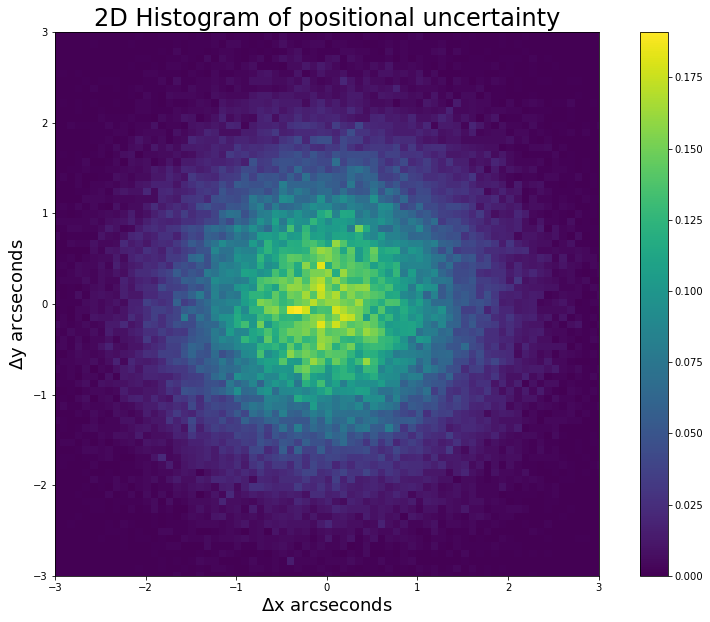

In [11]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax);

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

## 1.

We know that our 2D Gaussian is related to a Rayleigh distribution, such that our Rayleigh distribution will have a standard deviation of $ \sqrt{\sigma} $ if the Gaussians have a standard deviation of $ \sigma $. 

Let's state our statistical question in words:

_What is the distance in arcseconds that when integrated from the right up to that value (distance) corresponds to a probability of 5 'sigma'?_

## 2.

For a value V, Rayleigh distribution of $ R(x) $ and standard normal distribution of $ N(x) $:

$$ \int_{V}^{\infty}{ R(x) dx} = \int_{5\sigma}^{\infty}{ N(x) dx} $$

Then, we take the $isf()$ of the first integral to find the value of V.

(Thus, essentially, our mathematical question asks what is the value of V that makes this equation true.)

## 3.

In [12]:
prob_5sigma = 1/(3.5e6)
sigma_gaussian = 1
sigma_rayleigh = np.sqrt(sigma_gaussian)
rayleigh = stats.rayleigh(scale = sigma_rayleigh)
det = rayleigh.isf(prob_5sigma)
det
# stats.norm.isf(rayleigh.sf(prob_5sigma))

5.489676406940512

In [13]:
print(f'This means that the detection of movement of 5 sigma corresponds to {det} arcseconds')

This means that the detection of movement of 5 sigma corresponds to 5.489676406940512 arcseconds


## Problem 3

As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). We observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays. Let's find the signficance of our moon shadow detection.

## 1.

We assume the cosmic rays to follow a Poisson distribution, since we are dealing with rates of events (from cosmic rays).

In [14]:
(8 * u.hour).to(u.min)

<Quantity 480. min>

We state our statistical question:

_What is the probability that the "normally" occurring cosmic ray background produces a signal of 6800 cosmic rays for a Poisson distribution with a mean of 1 averaged with itself 480 times and boosted by a trial factor of 15?_

Remember, since we know that a Poisson distribution averaged with another Poisson distribution is just a Poisson distribution whose mean is the sum of the other Poisson distributions' means, we can restate our question:

_What is the probability that the "normally" occurring cosmic ray background produces a signal of 6800 cosmic rays for a Poisson distribution with a mean of 480, a rescaled x-axis that is divided by 480, and a trial factor of 15?_

## 2.

We will let $S = 6800$.

We start by showing the background for an 8 hour exposure (1 night).

In [15]:
intInterval = 480
trials = 15
mu = 1

background = stats.poisson(mu*N)

xmin, xmax = (0, 1000)
x = np.arange(xmin, xmax+1, resolution)
cx = np.arange(xmin, xmax+1, resolution/intInterval)
cxstairs = (np.arange(xmin, xmax+1+0.5*resolution/intInterval, resolution) - 0.5*resolution/intInterval)/intInterval

NameError: name 'N' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.tick_params(labelsize = lsize/2)
ax.stairs(poisson.pmf(x), cxstairs, fill=False)
ax.set_xlim([0.5, 1.5])
ax.set_xlabel('N cosmic rays', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('8 hours of exposure', fontsize = fsize, fontweight = 'bold')
plt.show()

The distribution above needs to be boosted by the **trial factor** 15. After doing this below, we get the following distribution:

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.tick_params(labelsize = lsize/2)
ax.stairs(poisson.pmf(x)*trialFactor, cxstairs, fill=False)
ax.set_xlim([0.5, 1.5])
ax.set_xlabel('N cosmic rays', fontsize = fsize)
ax.set_ylabel('Probability Mass', fontsize = fsize)
ax.set_title('15 days of 8-hour exposures', fontsize = fsize, fontweight = 'bold')
plt.show()

Which is the $pdf()$ of the background.

In [ ]:
S = 6800
N = intInterval
Y = S/trials
Y

Let's describe the integral that we need to do for a 6800 cosmic ray detection. If we see 6800 cosmic rays in the span of 15 days, we would have to see $ \frac{6800}{15} = 453.33 $ in our background distribution.

Since this value is smaller than the mean of the distribution $\mu$, we need to integrate from the left ($-\infty$) up to our value $Y = 453.33$. Our integral equation then becomes:

$$ \int_{-\infty}^{Y}{ P(x) dx} = \int_{\sigma}^{\infty}{ N(x) dx} $$

In [ ]:
prob_moon = (1 - background.cdf(Y)) / trials # We have to integrate from the left, since we are observing a deviation from the normal **less than** the mean
prob_moon

In [ ]:
print(f'The probability of detecting 6800 cosmic rays in our observation is {prob_moon:.2e}.')

## 3.

In [ ]:
sigma_moon = stats.norm.ppf(1-prob_moon)

In [ ]:
print(f'The sigma of our detection is {sigma_moon:.2}.')

This detection is significantly different from previous detections we have worked with in the past. In this scenario, we are looking for a 'lack' of cosmic rays coming from the patch of sky covered by the moon. Therefore, we have been dealing with taking the integral from the **left** up to our value $Y$.